In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.svm import SVC
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

In [2]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128
hidden_size = 128
hidden_layers = 3
epochs = 250
learning_rate=0.001
diffusion_steps = 1000
beta_start=0.001
beta_end=0.02
beta_schedule="quadratic" # "Linear" or "quadratic"
condition_dropout = 0.25

In [3]:
def moons_dataset(n=8000):
    X, y = make_moons(n_samples=n, random_state=42, noise=0.03)
    X[:, 0] = (X[:, 0] - 0.5) * 2.5
    X[:, 1] = (X[:, 1] - 0.25) * 5
    return TensorDataset(torch.from_numpy(X.astype(np.float32)), torch.from_numpy(y.astype(np.float32)))

dataset = moons_dataset(batch_size*epochs)
dataloader = DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True)

In [4]:
class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"
                ):

        self.num_timesteps = num_timesteps
        
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2
        
        self.alphas = 1.0 - self.betas
        
        # required for self.get_variance
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.step_ddpm
        self.sqrt_inv_alphas = 1 / self.alphas**0.5
        self.one_minus_alphas = self.betas
        
        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5
                
    def add_noise(self, x_start, x_noise, timesteps):
        # eq. 4 in DDPM paper.
        
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def get_variance(self, t):
        # eq. 7 in DDPM paper.
        
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step_ddpm(self, model_output, timestep, sample):
        # line 4 of algorithm 2 in DDPM paper
        
        t = timestep

        s1 = self.sqrt_inv_alphas[t]
        s2 = self.one_minus_alphas[t] / self.sqrt_one_minus_alphas_cumprod[t]
        
        pred_prev_sample = s1 * (sample - s2 * model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample
        
        
    def step_ddim(self, model_output, timestep, timestep_prev, sample, eta=1):
        # Eq 12 in DDIM paper
        
        t      = timestep
        t_prev = timestep_prev
        
        alpha_t = self.alphas_cumprod[t].reshape(-1, 1)
        alpha_t_prev = self.alphas_cumprod[t_prev].reshape(-1, 1)
        
        sigma_t = eta * ((1-alpha_t_prev)/(1-alpha_t))**.5 * (1-(alpha_t/alpha_t_prev))**.5
        
        # predict x0
        s1 = (1-alpha_t)**.5
        s2 = alpha_t**.5
        s3 = alpha_t_prev **.5
        
        x0 = (sample - s1 * model_output) / s2
        t1 = s3 * x0
        
        # find direction pointing to xt
        s4 = (1 - alpha_t_prev - sigma_t**2)**.5
        t2 = s4 * model_output
        
        # noise
        noise = torch.randn_like(model_output)
        t3 = sigma_t * noise
        
        return t1 + t2 + t3
    
    def step_ddim_cls_guide(self, model_output, timestep, timestep_prev, sample, class_guidance, gamma, eta=1):
        t      = timestep
        t_prev = timestep_prev
        
        alpha_t = self.alphas_cumprod[t].reshape(-1, 1)
        alpha_t_prev = self.alphas_cumprod[t_prev].reshape(-1, 1)
        
        sigma_t = eta * ((1-alpha_t_prev)/(1-alpha_t))**.5 * (1-(alpha_t/alpha_t_prev))**.5
        
        # steer model_output using class_guidance
        s1 = (1-alpha_t)**.5
        
        model_output_guided = model_output - gamma * s1 * class_guidance
        
        # predict x0
        
        s2 = alpha_t**.5
        s3 = alpha_t_prev **.5
        
        x0 = (sample - s1 * model_output_guided) / s2
        t1 = s3 * x0
        
        # find direction pointing to xt
        s4 = (1 - alpha_t_prev - sigma_t**2)**.5
        t2 = s4 * model_output_guided
        
        # noise
        noise = torch.randn_like(model_output)
        t3 = sigma_t * noise
        
        return t1 + t2 + t3

    def step_ddim_cls_free_guide(self, model_output_unconditional, model_output_conditional, timestep, timestep_prev, sample, gamma, eta=1):
        t      = timestep
        t_prev = timestep_prev
        
        alpha_t = self.alphas_cumprod[t].reshape(-1, 1)
        alpha_t_prev = self.alphas_cumprod[t_prev].reshape(-1, 1)
        
        sigma_t = eta * ((1-alpha_t_prev)/(1-alpha_t))**.5 * (1-(alpha_t/alpha_t_prev))**.5
        
        # combine conditional and unconditional model_output
        model_output = gamma * model_output_conditional + (1-gamma) * model_output_unconditional
        
        # predict x0
        s1 = (1-alpha_t)**.5
        s2 = alpha_t**.5
        s3 = alpha_t_prev **.5
        
        x0 = (sample - s1 * model_output) / s2
        t1 = s3 * x0
        
        # find direction pointing to xt
        s4 = (1 - alpha_t_prev - sigma_t**2)**.5
        t2 = s4 * model_output
        
        # noise
        noise = torch.randn_like(model_output)
        t3 = sigma_t * noise
        
        return t1 + t2 + t3
    
    
    def __len__(self):
        return self.num_timesteps

noise_scheduler = NoiseScheduler(
                    num_timesteps=diffusion_steps,
                    beta_start=beta_start,
                    beta_end=beta_end,
                    beta_schedule=beta_schedule
                    )

In [5]:
# model

class Block(nn.Module):
    def __init__(self, size):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))
        
class Diffusion_MLP(nn.Module):
    def __init__(self, hidden_size, hidden_layers, conditional=False):
        super().__init__()

        # make projection layer such that 
        # after concatenation of projected time and input
        # we get specified hidden_size

        self.conditional = conditional
        if self.conditional:
            emb_size = hidden_size//4
            self.input_mlp = nn.Linear(2, 2*emb_size)
            self.time_mlp = nn.Linear(1, emb_size)            
            self.condition_mlp = nn.Linear(1, hidden_size-3*emb_size)
        else:
            emb_size = hidden_size//3
            self.input_mlp = nn.Linear(2, 2*emb_size)
            self.time_mlp = nn.Linear(1, hidden_size-2*emb_size)
        
        # layers
        layers = [Block(hidden_size) for _ in range(hidden_layers)]
        layers.append(nn.Linear(hidden_size, 2))
        self.layers = nn.Sequential(*layers)

    def forward(self, x, t, c=None):
        x_emb = self.input_mlp(x)
        t_emb = self.time_mlp(t)
        if self.conditional:
            c_emb = self.condition_mlp(c)
            x = torch.cat((x_emb, t_emb, c_emb), dim=-1)
        else:
            x = torch.cat((x_emb, t_emb), dim=-1)
        x = self.layers(x)
        return x

In [6]:
model = Diffusion_MLP(
                    hidden_size=hidden_size,
                    hidden_layers=hidden_layers,
                    )

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
)

 epoch 0, loss 73.22634887695312
 epoch 1, loss 6.612004280090332
 epoch 2, loss 4.095000267028809
 epoch 3, loss 5.460099697113037
 epoch 4, loss 2.8415098190307617
 epoch 5, loss 7.513908386230469
 epoch 6, loss 1.8686323165893555
 epoch 7, loss 1.1722222566604614
 epoch 8, loss 5.938565254211426
 epoch 9, loss 1.3439276218414307
 epoch 10, loss 3.037233352661133
 epoch 11, loss 1.2119702100753784
 epoch 12, loss 4.392760753631592
 epoch 13, loss 9.984649658203125
 epoch 14, loss 0.6512908935546875
 epoch 15, loss 1.472447395324707
 epoch 16, loss 0.6218131184577942
 epoch 17, loss 0.9512442350387573
 epoch 18, loss 1.1285549402236938
 epoch 19, loss 1.195942997932434
 epoch 20, loss 2.863645553588867
 epoch 21, loss 0.7184206247329712
 epoch 22, loss 1.4109792709350586
 epoch 23, loss 1.3932925462722778
 epoch 24, loss 1.2275333404541016
 epoch 25, loss 6.1857404708862305
 epoch 26, loss 0.5243221521377563
 epoch 27, loss 0.5520533323287964
 epoch 28, loss 0.6131595373153687
 epoch 

 epoch 230, loss 0.3972738981246948
 epoch 231, loss 0.39427098631858826
 epoch 232, loss 0.3923760652542114
 epoch 233, loss 0.40158265829086304
 epoch 234, loss 0.3970714509487152
 epoch 235, loss 0.4013022184371948
 epoch 236, loss 0.39275336265563965
 epoch 237, loss 0.39706850051879883
 epoch 238, loss 0.3958909511566162
 epoch 239, loss 0.39956462383270264
 epoch 240, loss 0.39270272850990295
 epoch 241, loss 0.39813217520713806
 epoch 242, loss 0.387691855430603
 epoch 243, loss 0.39818111062049866
 epoch 244, loss 0.3970082998275757
 epoch 245, loss 0.4000647962093353
 epoch 246, loss 0.40523073077201843
 epoch 247, loss 0.3938499987125397
 epoch 248, loss 0.3946469724178314
 epoch 249, loss 0.40098434686660767


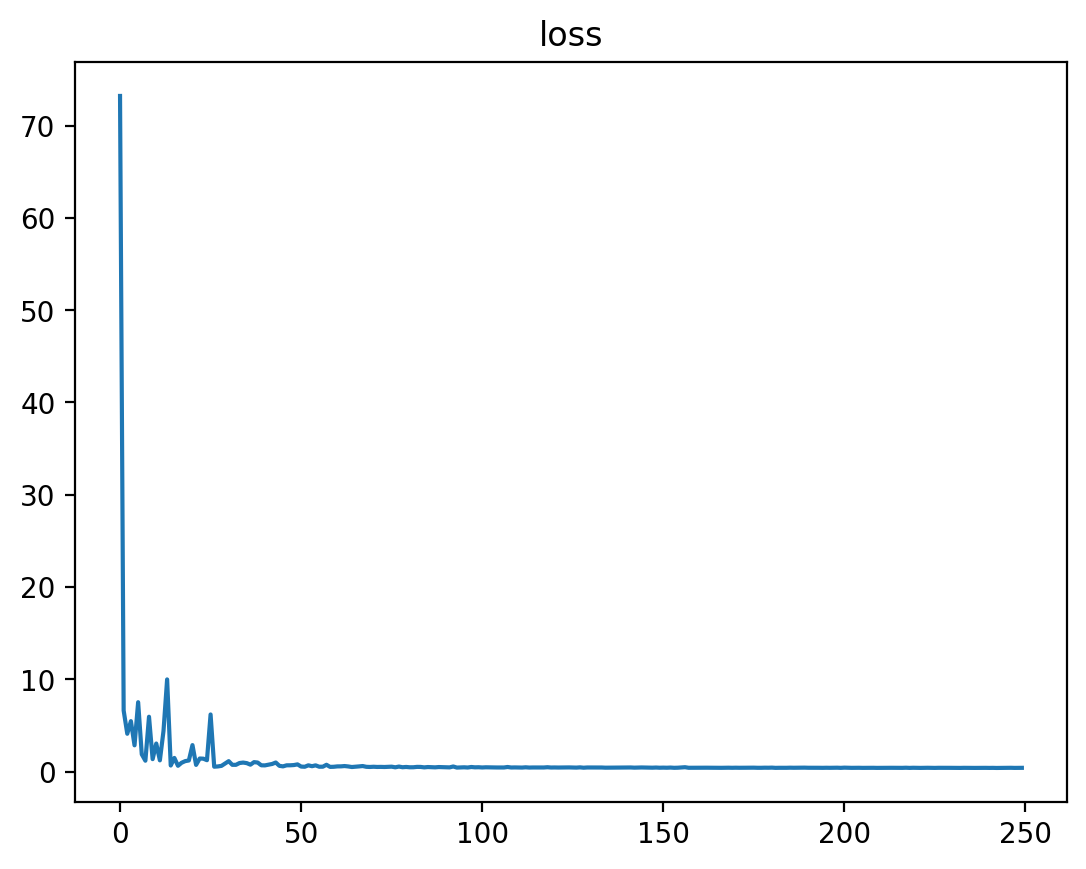

In [7]:
# Training

model.train()
avg_loss = []

for epoch in range(epochs):
    epoch_loss = []
    for batch_id, (data, label) in enumerate(dataloader):

        noise = torch.randn_like(data)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (data.shape[0],)
        ).long()

        noisy = noise_scheduler.add_noise(data, noise, timesteps)
        noise_pred = model(noisy, timesteps[:,None].float())
        loss = F.mse_loss(noise_pred, noise)
        epoch_loss.append(loss.item())

        # backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # visualize prediction result
        if False: #(epoch%10==0) and (batch_id==0):
            clean_data = remove_noise(data_with_noise, noise_pred.detach(), alpha_t_dash_[:,None])
            plt.figure(figsize=(5,5))
            plt.scatter(data[:,0].cpu(), data[:,1].cpu(), label='target')
            plt.scatter(data_with_noise[:,0].cpu(),data_with_noise[:,1].cpu(), label='input: target with noise')
            plt.scatter(clean_data[:,0].cpu(),clean_data[:,1].cpu(), label='predicted')
            plt.title(f'epoch = {epoch}')
            plt.legend()
            plt.show()
            
    avg_loss.append(torch.tensor(epoch_loss).mean())
    print(f' epoch {epoch}, loss {avg_loss[-1]}')
    
plt.figure()
plt.plot(avg_loss)
plt.title("loss")
plt.show()

## Sampling using DDIM

reducing steps from 1000 to 200


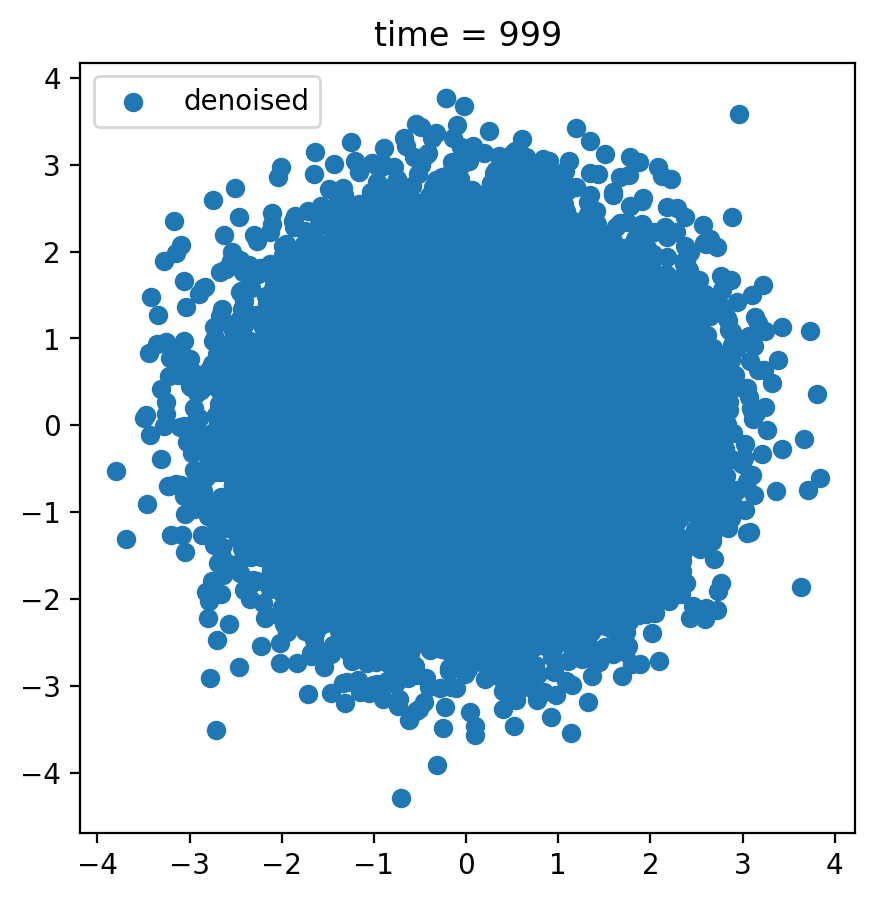

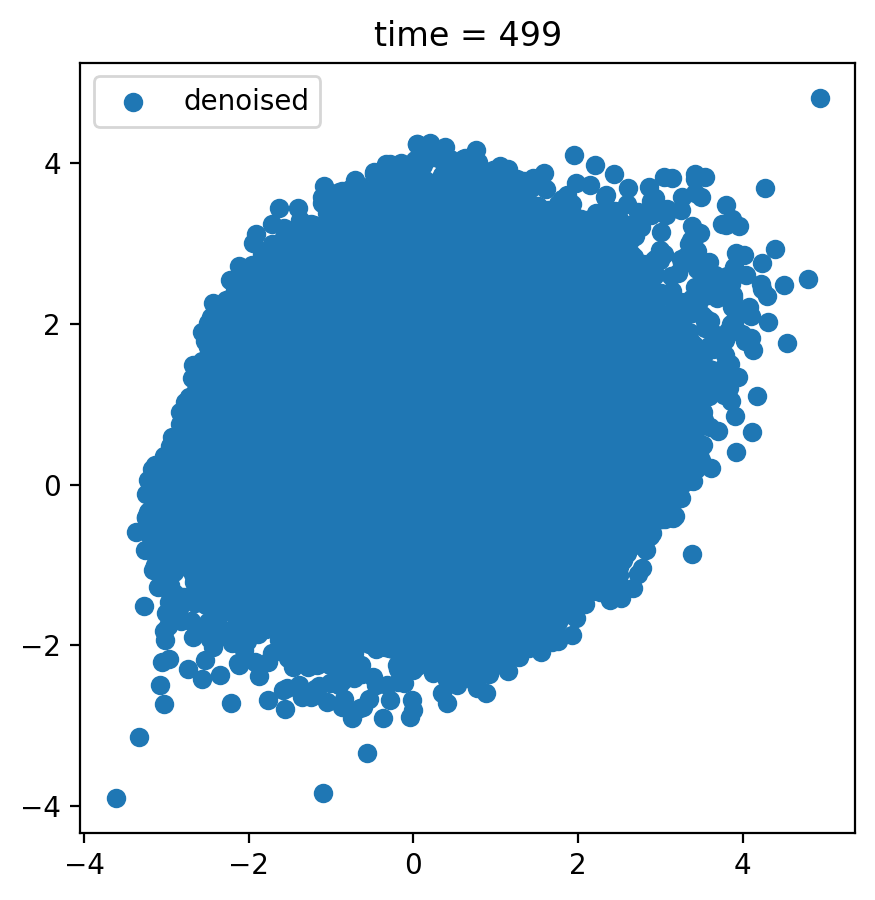

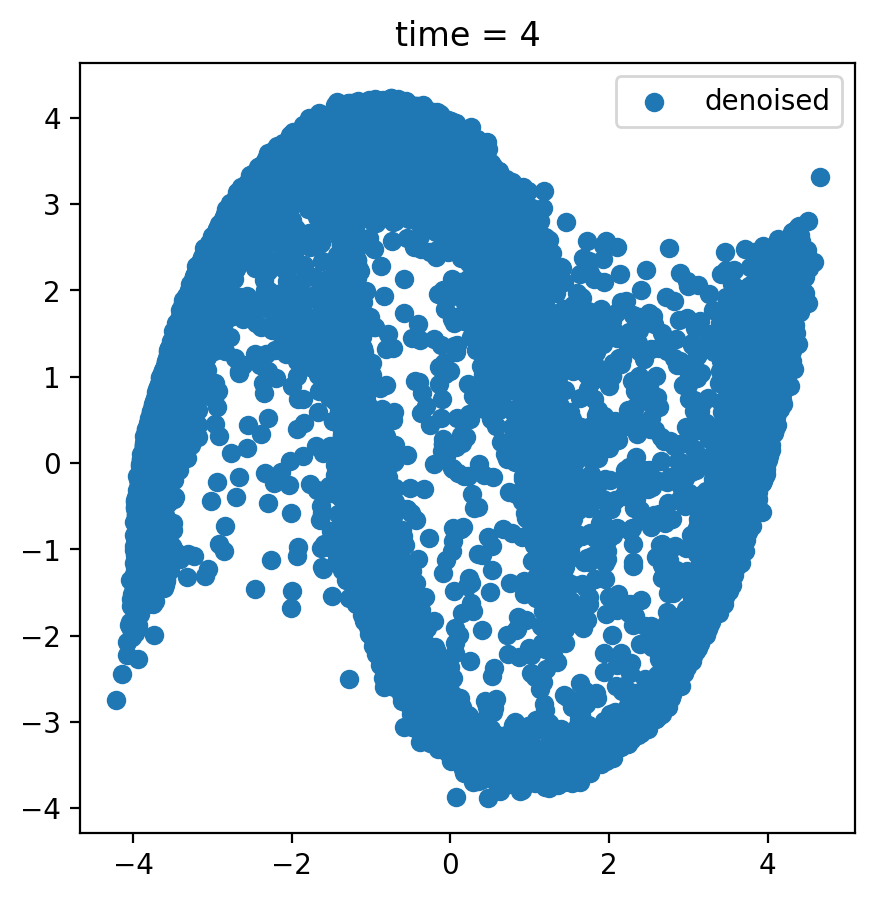

In [8]:
# Evaluation

model.eval()
eval_points = batch_size * epochs
sample = torch.randn(eval_points, 2)
orig_sample = sample.clone()

timesteps = list(range(len(noise_scheduler)))[::-5]
timesteps_prev = timesteps[1:] + [0]

print(f'reducing steps from {diffusion_steps} to {len(timesteps)}')
for i, (t, t_prev) in enumerate(zip(timesteps, timesteps_prev)):
    time = torch.from_numpy(np.repeat(t, eval_points)).long()
    time_prev = torch.from_numpy(np.repeat(t_prev, eval_points)).long()
    with torch.no_grad():
        residual = model(sample, time[:,None].float())
        
    # eta = 1 DDIM = DDPM -> non-deterministic
    # eta = 0 -> deterministic
    sample = noise_scheduler.step_ddim(residual, time, time_prev, sample, eta=0)
    
    # visualize prediction result
    if (i%100 == 0) or (i==(len(timesteps)-1)):    
        plt.figure(figsize=(5,5))
        plt.scatter(sample[:,0].cpu(), sample[:,1].cpu(), label='denoised')
        plt.title(f'time = {t}')
        plt.legend()
        plt.show()

## Classifier Guidance

epoch 0 loss 8.398681529797614e-05
epoch 1 loss 2.452223088766914e-05
epoch 2 loss 1.1065901162510272e-05
epoch 3 loss 2.4135515559464693e-05
epoch 4 loss 7.7858048825874e-06
epoch 5 loss 8.334297490364406e-06
epoch 6 loss 4.483373686525738e-06
epoch 7 loss 8.771103239268996e-06
epoch 8 loss 0.0004170451720710844
epoch 9 loss 2.7324933853378752e-06


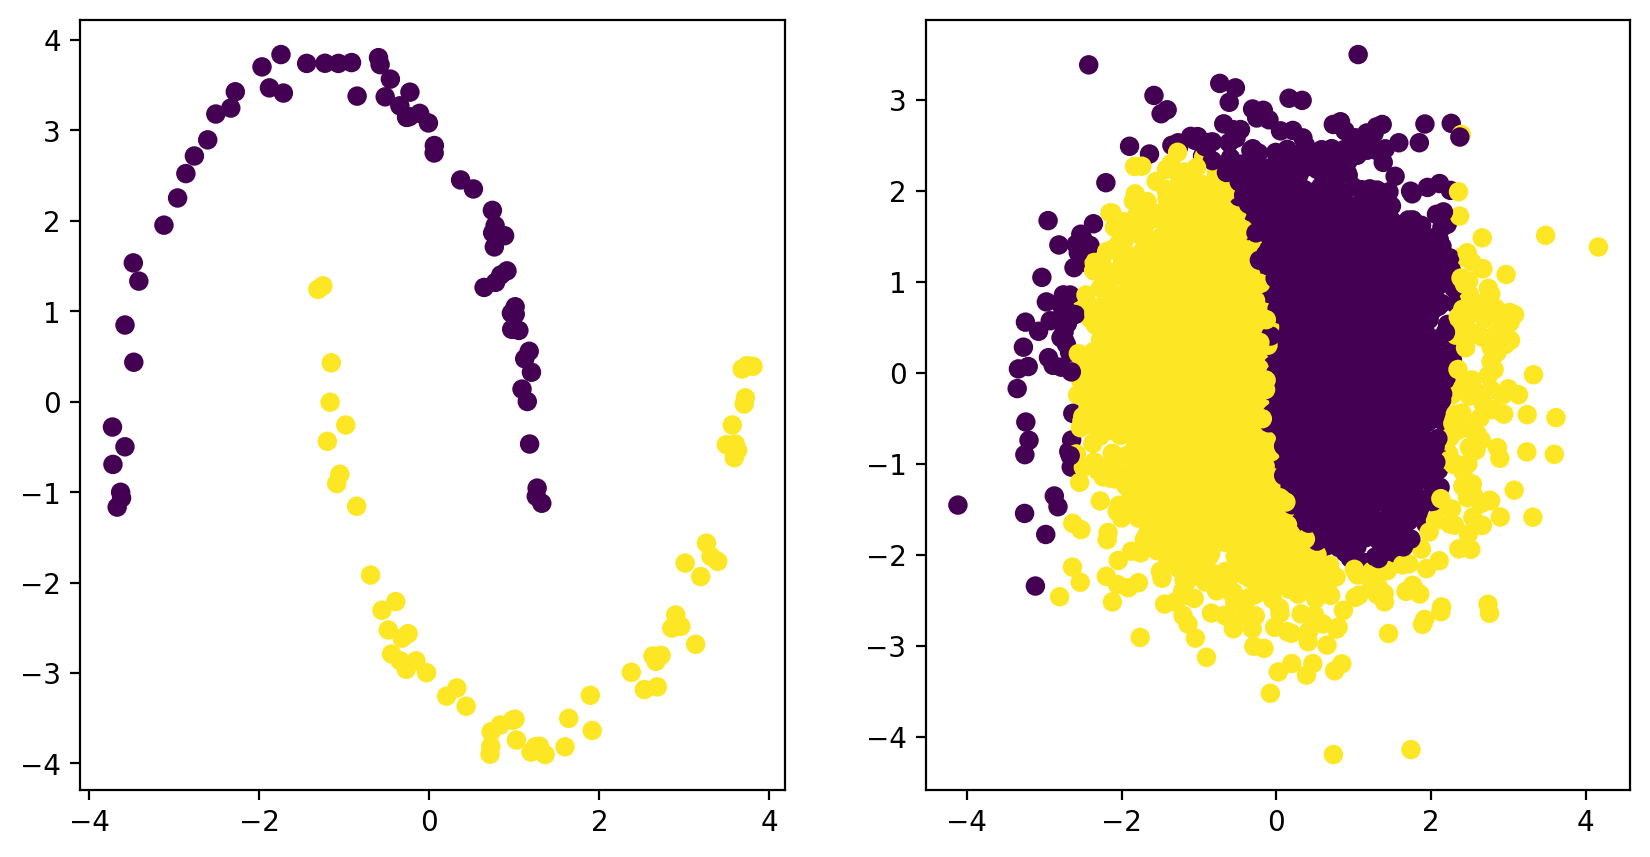

In [9]:
# train a classifier for guidance

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
        nn.Linear(2, 32),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        nn.Linear(32,128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Linear(128,32),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        nn.Linear(32,2),
        nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)

clf = NN()

clf_optimizer = torch.optim.AdamW(
    clf.parameters(),
    lr=0.01,
)

loss_fn = nn.NLLLoss()

# Training
clf.train()

for epoch in range(10):
    for batch_id, (data, label) in enumerate(dataloader):
        
        pred = clf(data)
        loss = loss_fn(pred, label.long())
        
        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()
        
    print(f'epoch {epoch} loss {loss.item()}')

# Evaluation
clf.eval()

with torch.no_grad():
    pred = clf(data)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(data[:,0], data[:,1], c=pred.argmax(-1))

data = torch.randn(8000, 2)
with torch.no_grad():
    pred = clf(data)
    
plt.subplot(122)
plt.scatter(data[:,0], data[:,1], c=pred.argmax(-1))
plt.show()

reducing steps from 1000 to 200


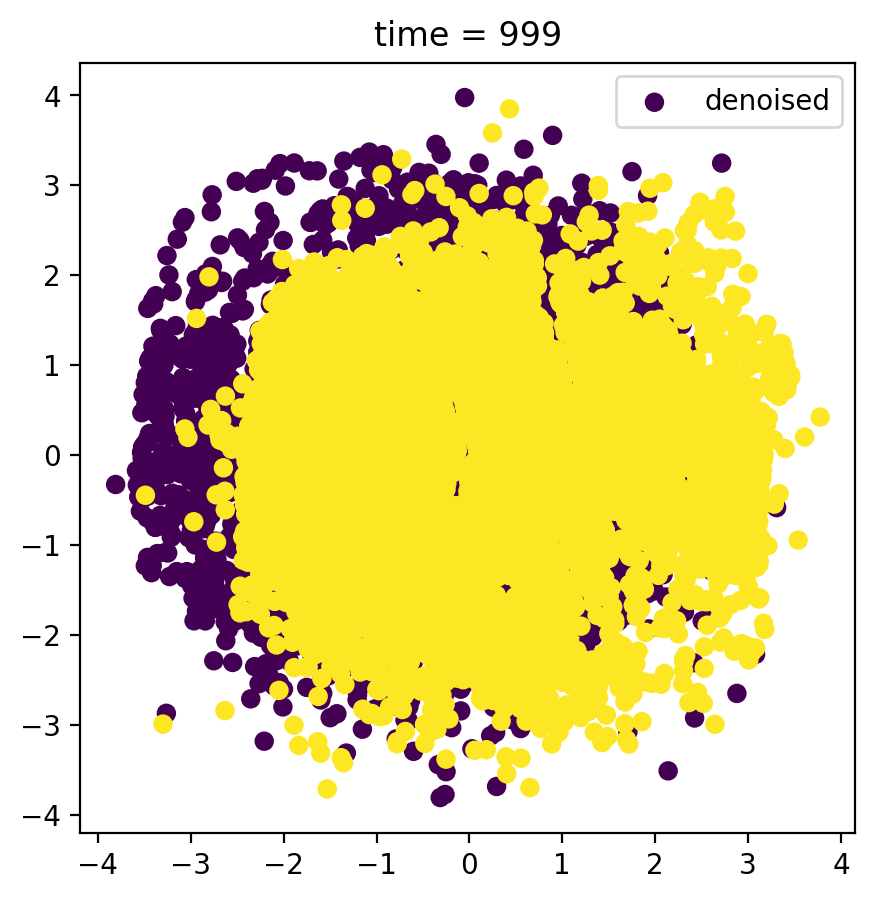

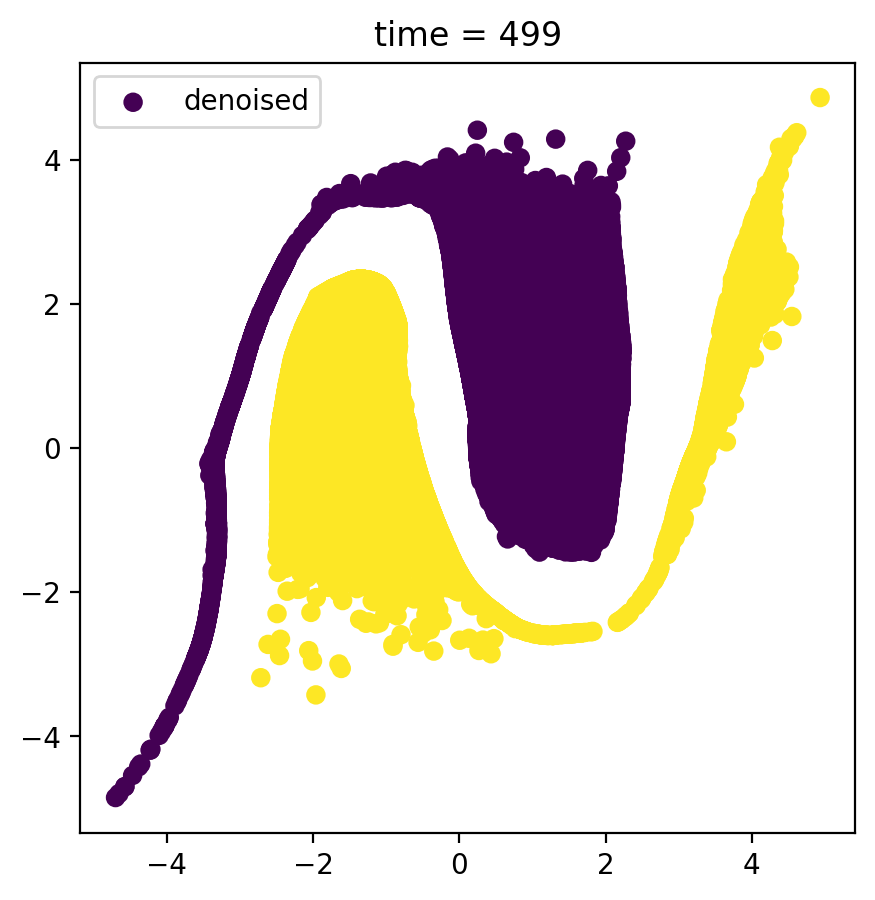

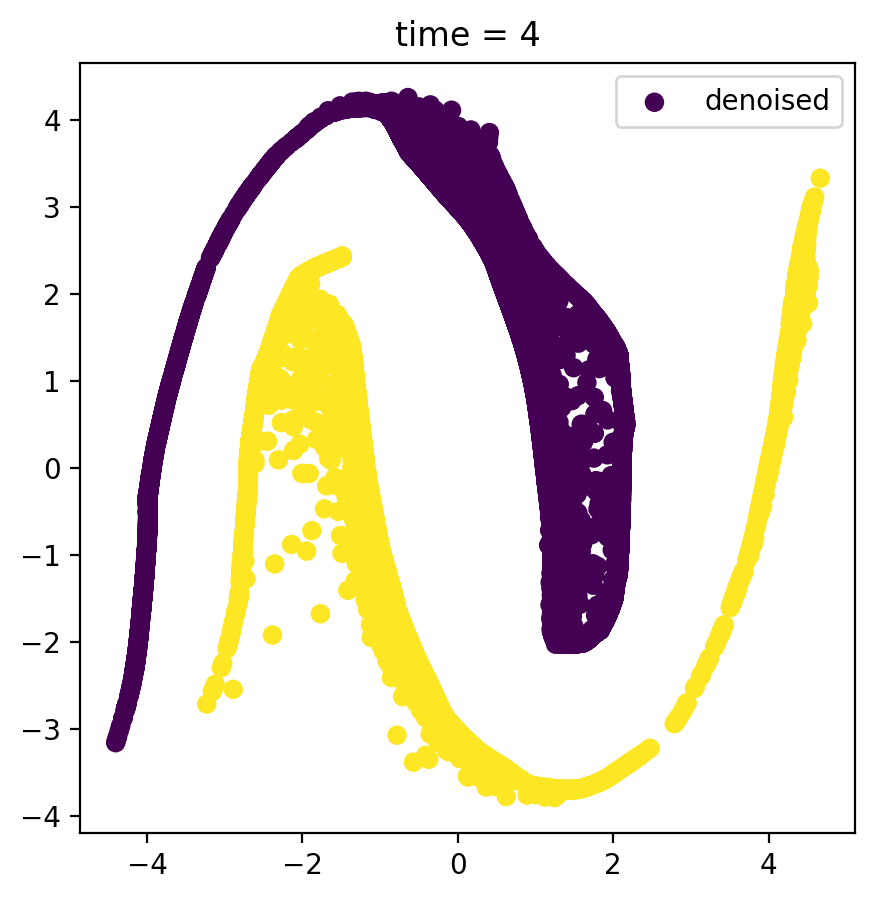

In [10]:
# Generate conditional samples

# play with gamma and eta
# eta = 1 DDIM = DDPM -> non-deterministic
# eta = 0 -> deterministic
# 0 <= gamma < 1 -> more emphasis on unconditional generation
# gamma >1 -> more emphasis on conditional generation

eta = 0
gamma = 1

model.eval()
clf.eval()
eval_points = batch_size * epochs
sample = torch.randn(eval_points, 2)
label = torch.cat([torch.zeros(eval_points//2), torch.ones(eval_points-eval_points//2)]).long()
orig_sample = sample.clone()

timesteps = list(range(len(noise_scheduler)))[::-5]
timesteps_prev = timesteps[1:] + [0]

print(f'reducing steps from {diffusion_steps} to {len(timesteps)}')
for i, (t, t_prev) in enumerate(zip(timesteps, timesteps_prev)):
    time = torch.from_numpy(np.repeat(t, eval_points)).long()
    time_prev = torch.from_numpy(np.repeat(t_prev, eval_points)).long()
    with torch.no_grad():
        residual = model(sample, time[:,None].float())

    # find classifier guidance
    sample.requires_grad = True
    class_prob = clf(sample)
    class_prob[range(eval_points),label[range(eval_points)]].backward(torch.ones(eval_points, 1).squeeze())
    class_guidance = sample.grad.clone()
    sample.requires_grad = False
    
    # update sample
    sample = noise_scheduler.step_ddim_cls_guide(residual, time, time_prev, sample, class_guidance, gamma=gamma, eta=eta)
    
    # visualize prediction result
    if (i%100 == 0) or (i==(len(timesteps)-1)):    
        plt.figure(figsize=(5,5))
        plt.scatter(sample[:,0].cpu(), sample[:,1].cpu(), c=label, label='denoised')
        plt.title(f'time = {t}')
        plt.legend()
        plt.show()

## Classifier-free Guidance

In [11]:
model = Diffusion_MLP(
                    hidden_size = hidden_size,
                    hidden_layers = hidden_layers,
                    conditional = True
                    )

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
)

 epoch 0, loss 165.47938537597656
 epoch 1, loss 2.416757822036743
 epoch 2, loss 1.6258735656738281
 epoch 3, loss 3.040719985961914
 epoch 4, loss 0.986042857170105
 epoch 5, loss 2.6008493900299072
 epoch 6, loss 1.6923049688339233
 epoch 7, loss 1.0787781476974487
 epoch 8, loss 1.5714446306228638
 epoch 9, loss 2.8750643730163574
 epoch 10, loss 0.8308172821998596
 epoch 11, loss 0.943845272064209
 epoch 12, loss 1.7993128299713135
 epoch 13, loss 1.432382345199585
 epoch 14, loss 1.6320314407348633
 epoch 15, loss 0.8712209463119507
 epoch 16, loss 1.6104146242141724
 epoch 17, loss 1.246638298034668
 epoch 18, loss 2.0964245796203613
 epoch 19, loss 1.6632087230682373
 epoch 20, loss 0.7927713394165039
 epoch 21, loss 1.0728144645690918
 epoch 22, loss 1.4080302715301514
 epoch 23, loss 1.1093459129333496
 epoch 24, loss 0.9898952841758728
 epoch 25, loss 0.9603248238563538
 epoch 26, loss 1.0248258113861084
 epoch 27, loss 1.1647965908050537
 epoch 28, loss 0.8091195225715637
 

 epoch 230, loss 0.35645031929016113
 epoch 231, loss 0.3532860577106476
 epoch 232, loss 0.3612101972103119
 epoch 233, loss 0.3614397644996643
 epoch 234, loss 0.3557322919368744
 epoch 235, loss 0.36495280265808105
 epoch 236, loss 0.3508819043636322
 epoch 237, loss 0.3572794198989868
 epoch 238, loss 0.3554055094718933
 epoch 239, loss 0.3602367639541626
 epoch 240, loss 0.35688045620918274
 epoch 241, loss 0.34801173210144043
 epoch 242, loss 0.3571230471134186
 epoch 243, loss 0.35240423679351807
 epoch 244, loss 0.35306021571159363
 epoch 245, loss 0.35932257771492004
 epoch 246, loss 0.35391584038734436
 epoch 247, loss 0.35562434792518616
 epoch 248, loss 0.3475451171398163
 epoch 249, loss 0.3538825213909149


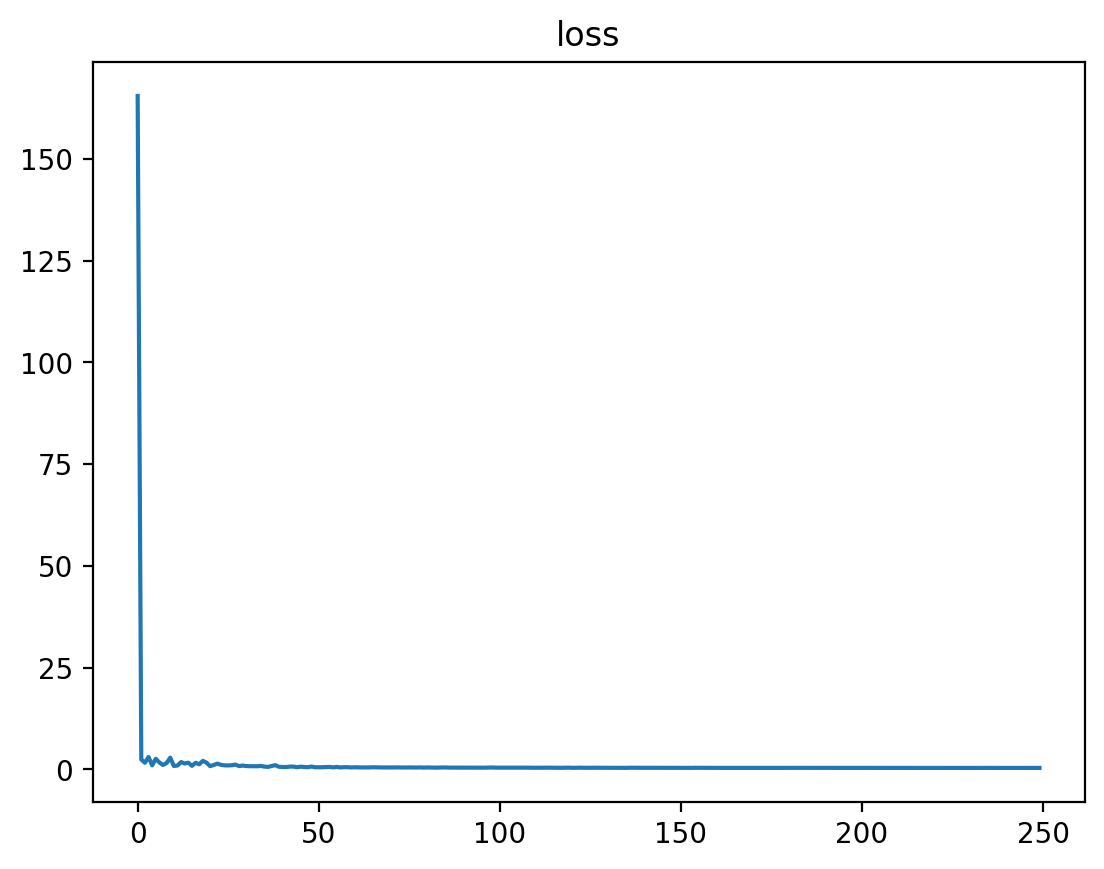

In [12]:
# Training

model.train()
avg_loss = []

for epoch in range(epochs):
    epoch_loss = []
    for batch_id, (data, label) in enumerate(dataloader):
    
        noise = torch.randn_like(data)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (data.shape[0],)
        ).long()

        noisy = noise_scheduler.add_noise(data, noise, timesteps)
        
        # condition dropout
        label[torch.randn_like(label)<condition_dropout] = -1
        
        noise_pred = model(noisy, timesteps[:,None].float(), label[:,None].float())
        loss = F.mse_loss(noise_pred, noise)
        epoch_loss.append(loss.item())

        # backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # visualize prediction result
        if False: #(epoch%10==0) and (batch_id==0):
            clean_data = remove_noise(data_with_noise, noise_pred.detach(), alpha_t_dash_[:,None])
            plt.figure(figsize=(5,5))
            plt.scatter(data[:,0].cpu(), data[:,1].cpu(), label='target')
            plt.scatter(data_with_noise[:,0].cpu(),data_with_noise[:,1].cpu(), label='input: target with noise')
            plt.scatter(clean_data[:,0].cpu(),clean_data[:,1].cpu(), label='predicted')
            plt.title(f'epoch = {epoch}')
            plt.legend()
            plt.show()
            
    avg_loss.append(torch.tensor(epoch_loss).mean())
    print(f' epoch {epoch}, loss {avg_loss[-1]}')
    
plt.figure()
plt.plot(avg_loss)
plt.title("loss")
plt.show()

reducing steps from 1000 to 200


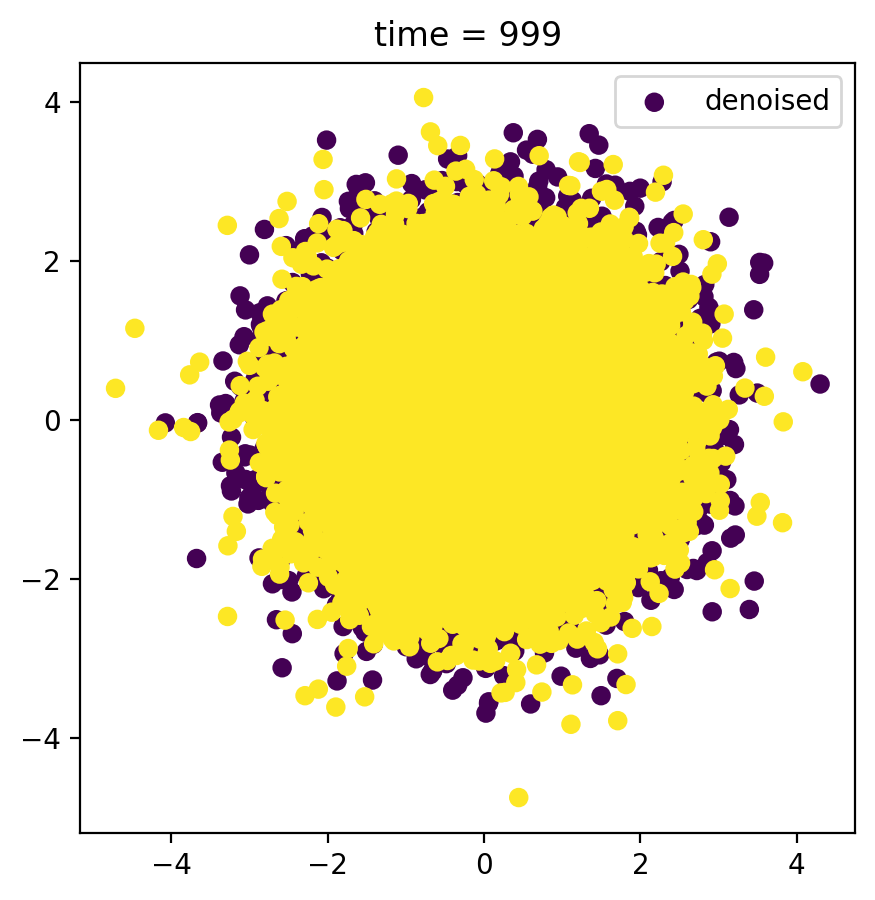

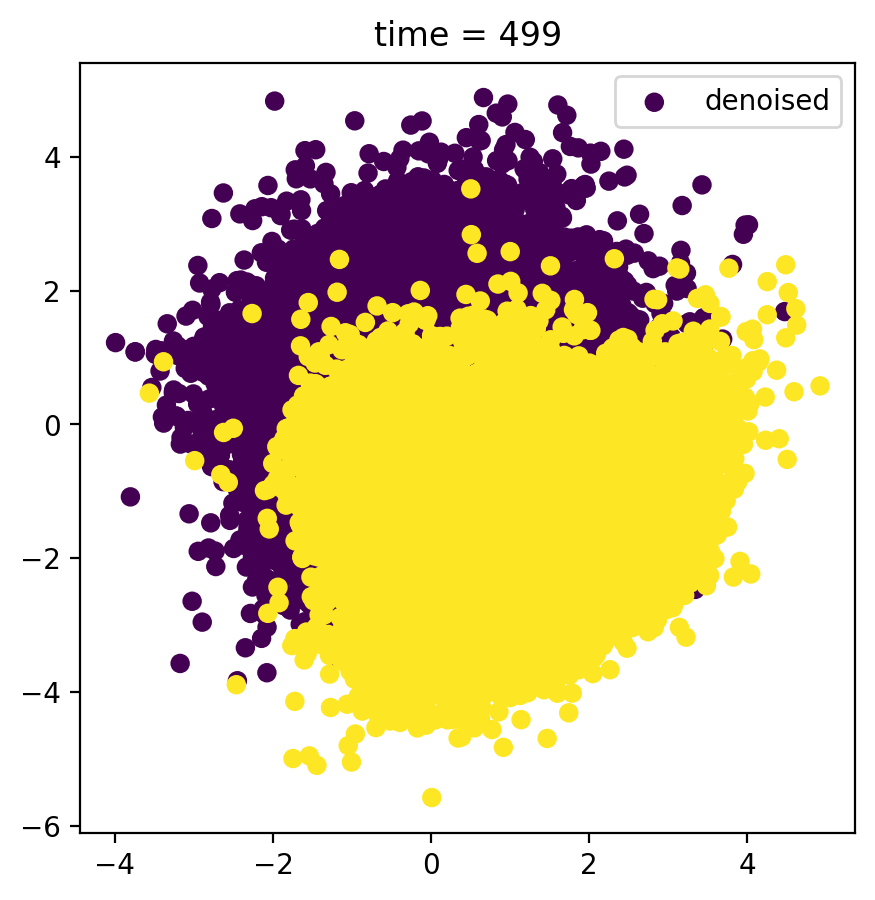

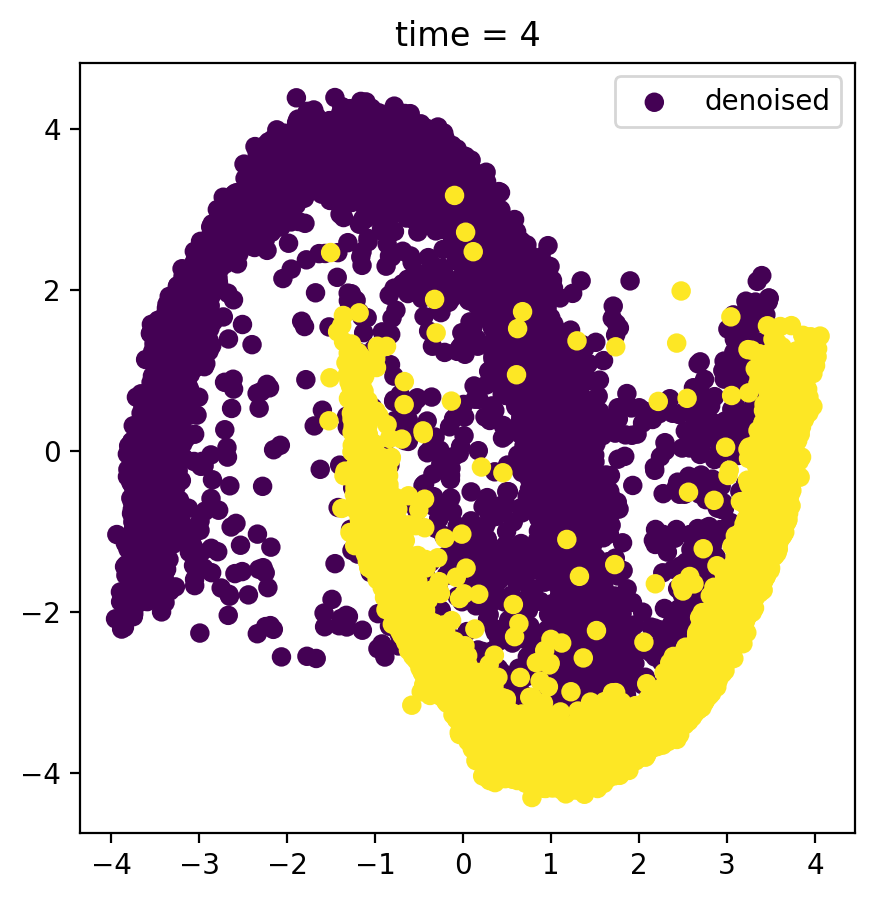

In [13]:
# Generate conditional samples

# play with gamma and eta
# eta = 1 DDIM = DDPM -> non-deterministic
# eta = 0 -> deterministic
# 0 <= gamma < 0.5 -> more emphasis on unconditional generation
# gamma > 0.5 -> more emphasis on conditional generation

eta = 0
gamma = 1

model.eval()
eval_points = batch_size * epochs
sample = torch.randn(eval_points, 2)
label_conditional = torch.cat([
    torch.zeros(eval_points//2),
    torch.ones(eval_points-eval_points//2)
    ]).long()
label_unconditional = -1 * torch.ones_like(label_conditional)
orig_sample = sample.clone()

timesteps = list(range(len(noise_scheduler)))[::-5]
timesteps_prev = timesteps[1:] + [0]

print(f'reducing steps from {diffusion_steps} to {len(timesteps)}')
for i, (t, t_prev) in enumerate(zip(timesteps, timesteps_prev)):
    time = torch.from_numpy(np.repeat(t, eval_points)).long()
    time_prev = torch.from_numpy(np.repeat(t_prev, eval_points)).long()
    with torch.no_grad():
        residual_conditional = model(sample, time[:,None].float(), label_conditional[:,None].float())
        residual_unconditional = model(sample, time[:,None].float(), label_unconditional[:,None].float())

    # update sample
    sample = noise_scheduler.step_ddim_cls_free_guide(residual_unconditional, residual_conditional, time, time_prev, sample, gamma=gamma, eta=eta)
    
    # visualize prediction result
    if (i%100 == 0) or (i==(len(timesteps)-1)):    
        plt.figure(figsize=(5,5))
        plt.scatter(sample[:,0].cpu(), sample[:,1].cpu(), c=label_conditional, label='denoised')
        plt.title(f'time = {t}')
        plt.legend()
        plt.show()